# FXHash vs Hash Performance Analysis
This notebook analyzes benchmark results comparing FXHash and Hash performance over 10 runs with n=100.

In [11]:
import os
import json
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

def load_estimate(path: str) -> float:
    """
    estimates.json から mean の point_estimate(ns) を取得する
    Parameters
    ----------
    path : str
        estimates.json へのパス
    Returns
    -------
    float
        平均実行時間（ナノ秒）
    """
    with open(path, "r") as f:
        data = json.load(f)
    return data["mean"]["point_estimate"]

results = []
for run_dir in sorted(glob.glob("run_*")):
    for hash_dir in ("FxHashMap insert (String keys)",
                     "std HashMap insert (String keys)"):
        # new/ が無ければ base/ を見る
        for sub in ("new", "base"):
            est_path = os.path.join(run_dir, hash_dir, sub, "estimates.json")
            if os.path.exists(est_path):
                duration_ns = load_estimate(est_path)
                results.append({
                    "run": run_dir,
                    "hash_type": "FXHash" if hash_dir.startswith("FxHash") else "Hash",
                    "duration_ns": duration_ns
                })
                break  # new があれば base は読まない

df = pd.DataFrame(results)


## Data Processing and Statistical Analysis

In [12]:
# Calculate statistics per hash type
stats = df.groupby('hash_type').agg({
    'duration_ns': ['mean', 'std', 'min', 'max']
}).round(2)

stats.columns = ['mean_ns', 'std_ns', 'min_ns', 'max_ns']
stats = stats.reset_index()
stats

,hash_type,mean_ns,std_ns,min_ns,max_ns
0,FXHash,19839663.71,1295599.53,19033650.01,23445064.36
1,Hash,23980657.87,380202.50,23504673.83,24670527.51


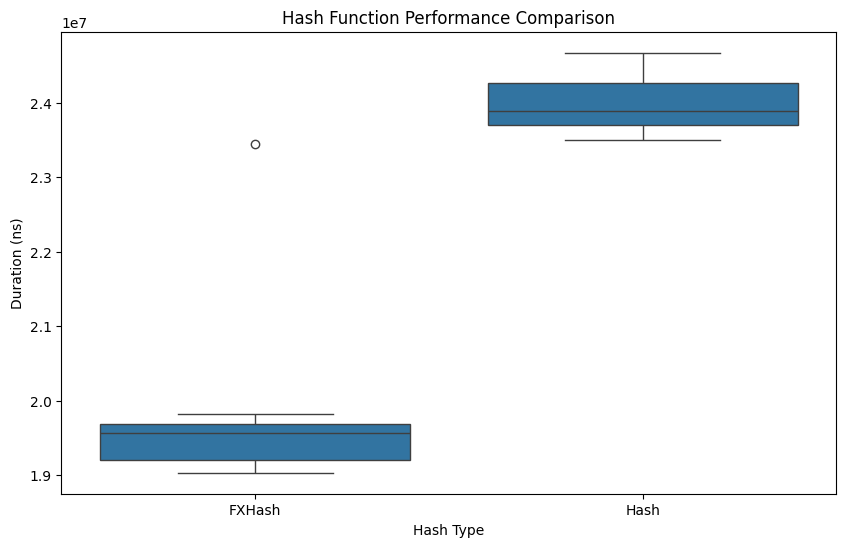

In [13]:
# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='hash_type', y='duration_ns')
plt.title('Hash Function Performance Comparison')
plt.xlabel('Hash Type')
plt.ylabel('Duration (ns)')
plt.show()

## Performance Difference Analysis

In [14]:
# Calculate performance difference 
fxhash_mean = df[df['hash_type'] == 'FXHash']['duration_ns'].mean()
hash_mean = df[df['hash_type'] == 'Hash']['duration_ns'].mean()
diff_percent = ((hash_mean - fxhash_mean) / fxhash_mean * 100).round(2)

print(f"FXHash mean duration: {fxhash_mean:.2f} ns")
print(f"Hash mean duration: {hash_mean:.2f} ns")
print(f"Performance difference: {diff_percent}%")

FXHash mean duration: 19839663.71 ns
Hash mean duration: 23980657.87 ns
Performance difference: 20.87%


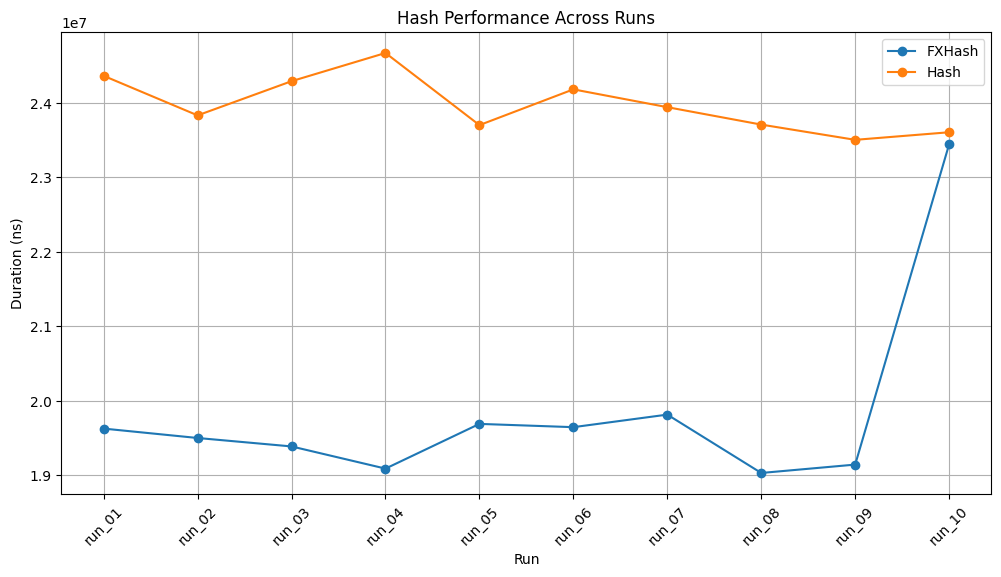

In [15]:
# Plot performance across runs
plt.figure(figsize=(12, 6))
for hash_type in df['hash_type'].unique():
    data = df[df['hash_type'] == hash_type]
    plt.plot(data['run'], data['duration_ns'], 'o-', label=hash_type)

plt.title('Hash Performance Across Runs')
plt.xlabel('Run')
plt.ylabel('Duration (ns)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
